<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from collections import Counter
from scipy.sparse import csr_matrix

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = '/tmp/working/machinlearning/6/ident/data/capstone_user' 

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    # Считали словарь
    with open(site_freq_path, 'rb') as f:
        site_freq = pickle.load(f)
    # Пути к нашим csv файлам
    paths = glob(os.path.join(path_to_csv_files,'user*.csv'))
    # Достаем csv файлы пользователей
    pd_list = []
    sites_list = []
    matrix_site_list = []
    timespan_list = []
    matrix_timespan_list = []
    y_list = []

    for i in range(len(paths)):
        pd_list.append(pd.read_csv(paths[i],sep = ',', header = 0))
        pd_list[i].timestamp = pd_list[i].timestamp.apply(pd.Timestamp)
        # Достаем все сайты из этих файлов
        sites_list.append(pd_list[i]['site'].values)
        
        timespan_list.append([])
        for j in range(len(pd_list[i]['timestamp'].values)):
            timespan_list[i].append(pd_list[i]['timestamp'][j])
        # Заменяем имена на id согласно словарю
        for j in range(len(sites_list[i])):
            sites_list[i][j] = site_freq[sites_list[i][j]][0]
        sites_list[i] = sites_list[i].tolist()
        # Допишем 0 согласно размеру сессии и ширине окна
        # Преобразуем в матрицу согласно размеру окна   
        
        for j in range(0,len(sites_list[i]),window_size):
            if j+session_length > len(sites_list[i]):
                matrix_site_list.append(sites_list[i][j:len(sites_list[i])])
                matrix_timespan_list.append(timespan_list[i][j:len(timespan_list[i])])
                for t in range(j+session_length - len(sites_list[i])):
                    matrix_site_list[len(matrix_site_list)-1].append(0)
            else:
                matrix_site_list.append(sites_list[i][j:j+session_length])
                matrix_timespan_list.append(timespan_list[i][j:j+session_length])
            y_list.append(int(paths[i][len(paths[i])-8:len(paths[i])-4]))
    
    
    session_timespan = []
    unique_sites = []
    start_hour = []
    day_of_week = []
    for i in range(len(matrix_site_list)):
        if matrix_site_list[i].count(0) == 0:
            unique_sites.append(len(np.unique(matrix_site_list[i])))
        else:
            unique_sites.append(len(np.unique(matrix_site_list[i]))-1)
    matrix_site_list = np.array(matrix_site_list)
    for i in range(len(matrix_timespan_list)):
        day_of_week.append(min(matrix_timespan_list[i]).dayofweek)
        start_hour.append(min(matrix_timespan_list[i]).hour)
        session_timespan.append((max(matrix_timespan_list[i]) - min(matrix_timespan_list[i])).seconds)
    sites_pd = pd.DataFrame()
    for i in range(session_length):
        sites_pd['site'+str(i+1)] = matrix_site_list.transpose()[i]
    sites_pd['session_timespan'] = session_timespan
    sites_pd['#unique_sites'] = unique_sites
    sites_pd['start_hour'] = start_hour
    sites_pd['day_of_week'] = day_of_week
    sites_pd['user_id'] = y_list
    
    
    return sites_pd

**Проверим функцию на игрушечном примере.**

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'user_id']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,4,2,2,10,2,1,8,6,9,11,7998,8,9,4,1
1,4,1,1,1,0,0,0,0,0,0,60,2,12,4,1
2,4,2,5,5,2,0,0,0,0,0,7935,3,9,4,2
3,3,1,2,1,2,1,1,6,7,3,7998,5,9,4,3
4,3,1,2,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [6]:
%%time
train_data_10users = prepare_train_set_with_fe (os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

CPU times: user 5.32 s, sys: 52 ms, total: 5.37 s
Wall time: 5.37 s


In [7]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,39,39,255,39,39,653,3,31,772,193,1545,7,8,4,33
1,31,242,2,6,3,2,2,6,3,2,20,5,8,4,33
2,242,242,43,242,2,2,3394,2,2483,2483,1042,5,8,4,33
3,242,2,2,2,63,54,86,143,54,63,23,6,9,4,33
4,2,54,143,54,63,242,2,2,2483,3,2518,7,9,4,33


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [8]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

CPU times: user 51.9 s, sys: 624 ms, total: 52.5 s
Wall time: 52.5 s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [9]:
new_features_10users = train_data_10users[['user_id','session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users[['user_id','session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]

In [10]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [11]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['user_id'].map(id_name_dict)
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id,target
0,192,574,133,3,133,133,3,133,203,133,33,5,8,4,31,John
1,415,193,674,254,133,31,393,3305,217,55,284,10,8,4,31,John
2,55,3,55,55,5,293,415,333,897,55,258,7,8,4,31,John
3,473,3306,473,55,55,55,55,937,199,123,30,6,8,4,31,John
4,342,55,5,3307,258,211,3308,2086,675,2086,6,9,8,4,31,John


In [12]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

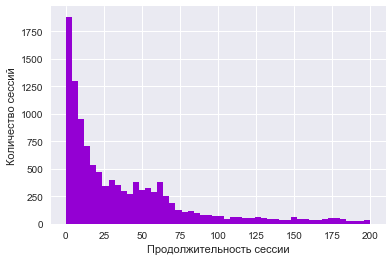

In [13]:
train_data_10users[train_data_10users.session_timespan <= 200]['session_timespan'].hist(facecolor = 'darkviolet', bins = 50)
plt.xlabel(u'Продолжительность сессии')
plt.ylabel(u'Количество сессий')

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

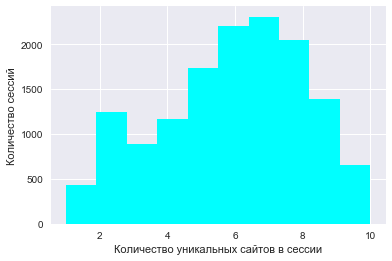

In [14]:
train_data_10users['#unique_sites'].hist(facecolor = 'aqua')
plt.xlabel(u'Количество уникальных сайтов в сессии')
plt.ylabel(u'Количество сессий')

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

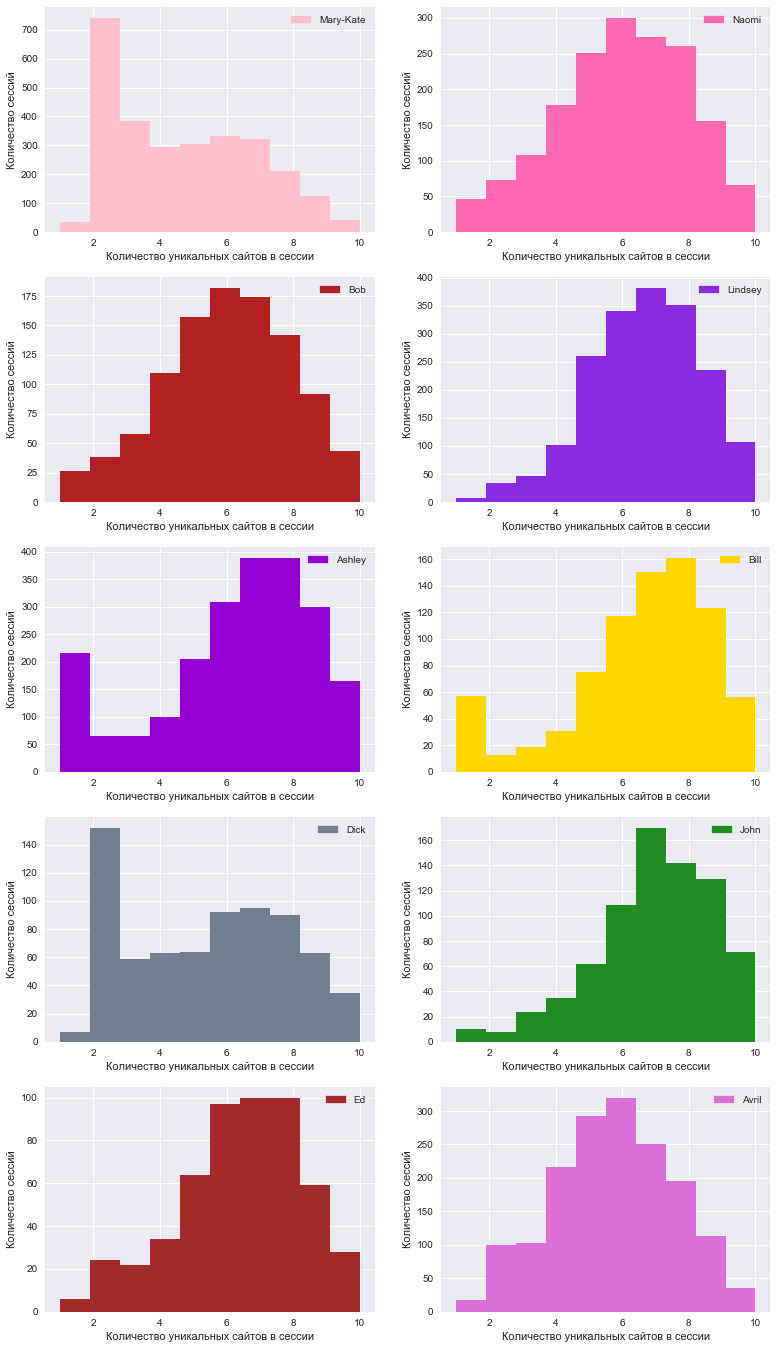

In [20]:
import matplotlib.patches as mpatches
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(13, 24))

for i in range(len(color_dic)):
    axes[i%5][i%2].hist(train_data_10users[train_data_10users.target == color_dic.keys()[i]]['#unique_sites'],facecolor = color_dic.values()[i])
    patch = mpatches.Patch(color=color_dic.values()[i], label=color_dic.keys()[i])
    axes[i%5][i%2].legend(handles=[patch])
    axes[i%5][i%2].set_xlabel(u'Количество уникальных сайтов в сессии')
    axes[i%5][i%2].set_ylabel(u'Количество сессий')


**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

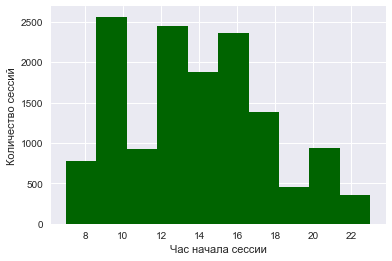

In [21]:
train_data_10users['start_hour'].hist(facecolor = 'darkgreen')
plt.xlabel(u'Час начала сессии')
plt.ylabel(u'Количество сессий')

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

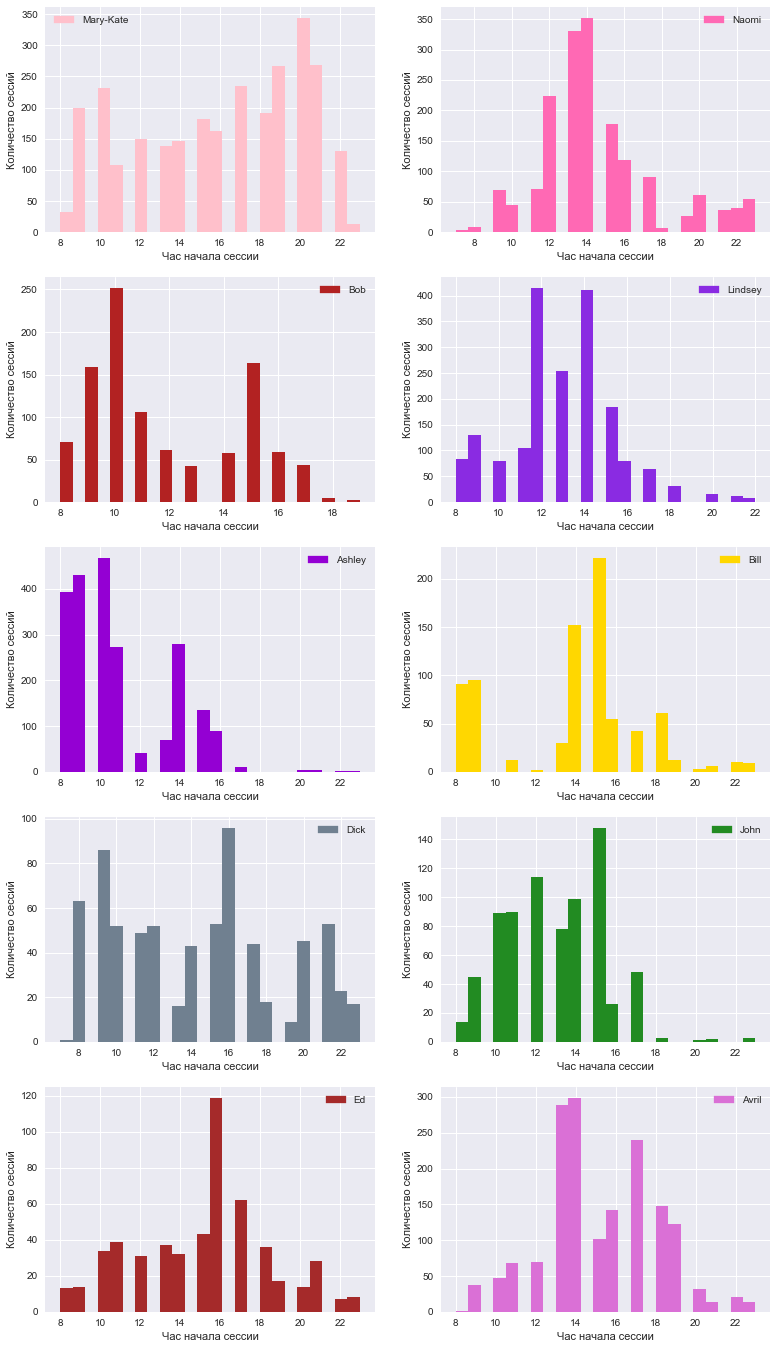

In [22]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(13, 24))
for i in range(len(color_dic)):
    axes[i%5][i%2].hist(train_data_10users[train_data_10users.target == color_dic.keys()[i]]['start_hour'],bins = 24,facecolor = color_dic.values()[i])
    patch = mpatches.Patch(color=color_dic.values()[i], label=color_dic.keys()[i])
    axes[i%5][i%2].legend(handles=[patch])
    axes[i%5][i%2].set_xlabel(u'Час начала сессии')
    axes[i%5][i%2].set_ylabel(u'Количество сессий')


**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

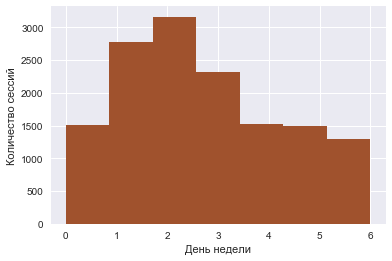

In [23]:
train_data_10users['day_of_week'].hist(bins = 7, facecolor = 'sienna')
plt.xlabel(u'День недели')
plt.ylabel(u'Количество сессий')

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

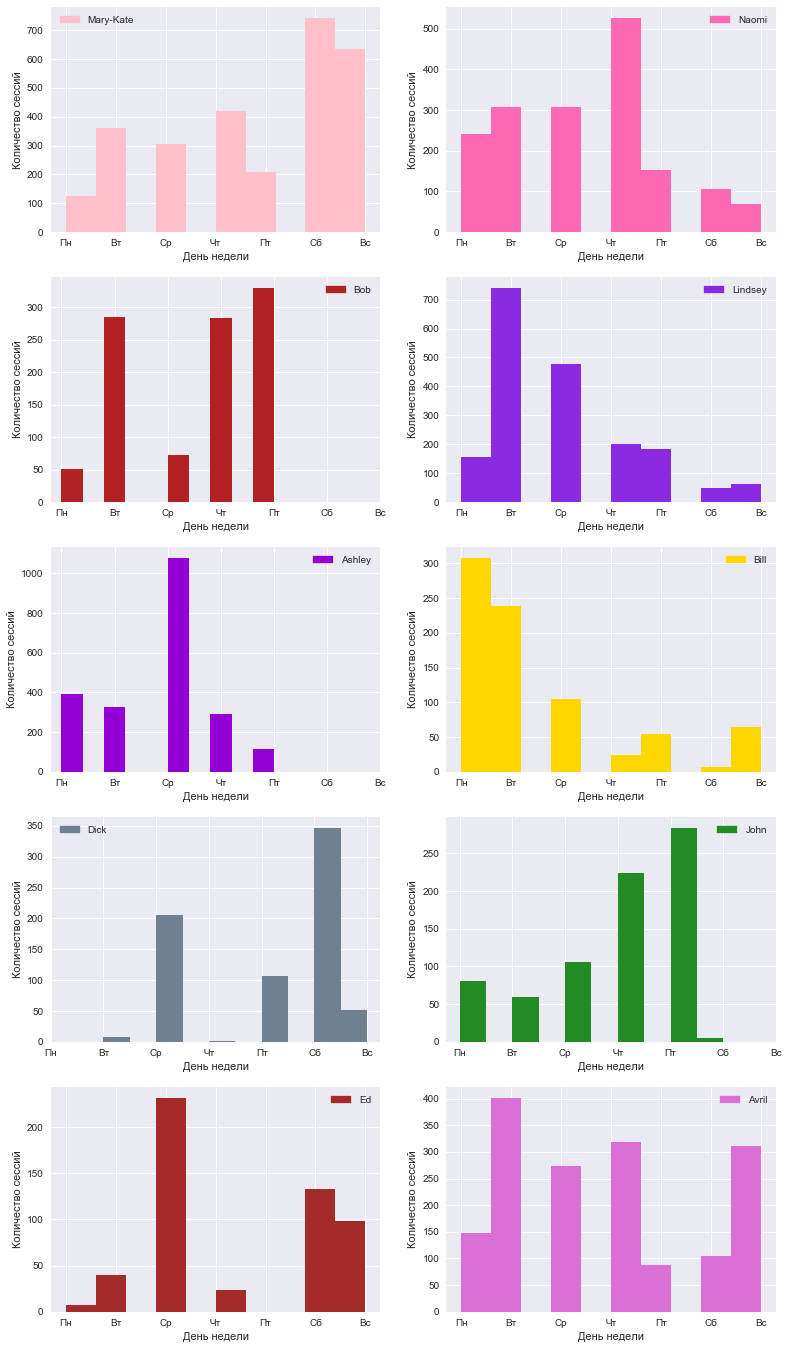

In [24]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(13, 24))
days = [u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб', u'Вс']
for i in range(len(color_dic)):
    axes[i%5][i%2].hist(train_data_10users[train_data_10users.target == color_dic.keys()[i]]['day_of_week'],facecolor = color_dic.values()[i])
    patch = mpatches.Patch(color=color_dic.values()[i], label=color_dic.keys()[i])
    axes[i%5][i%2].legend(handles=[patch])
    axes[i%5][i%2].set_xlabel(u'День недели')
    axes[i%5][i%2].set_ylabel(u'Количество сессий')
    axes[i%5][i%2].set_xticks(range(7))
    axes[i%5][i%2].set_xticklabels([days[i%7] for i in range(7)])


**8. Сделайте выводы про каждого пользователя по построенным графикам.**

### Количество уникальных сайтов

Пользователи Mary-Kate и Dick в основном сидят на 2 сайтах в сессии. Остальные пользователи в среднем посещают 6-7 сайтов.

### Час начала сессии

Пользователи Mary-Kate и Ashley обычно сидят вечером

Пользователи Naomi, Lindsey, Bill, Ed, Avrill обычно сидят днем

Пользователи Bob и John обычно сидят днем и вечером

Пользователь Dick - ярый фанат интернета и сидит весь день:)

Всех "вечерних" и Dick я бы взял на заметку:)

### День недели

В понедельник активен только Bob. Во вторник - Bob, Lindsey, Bill, Avrill. Среда - Dick, Ed, Ashley (причем Ashley активна только в рабочие дни). Четверг - Naomi, Bob, John, Avrill. Пятница - Bob, John. Суббота - Mary-Kate, Dick. Воскресенье - Mary-Kate, Avrill.

Подытожим: пользователь Dick сидит в основном на двух сайтах практически каждый день, для хаккера количество сайтов маловато, скорей всего это просто соц. сети и т.д. Ashley активна в рабочие дни, скорей всего так и есть, она сидит в интернете по вопросам работы, ну или во время работы). Mary-Kate сидит по выходным, скорей всего у человека активная работа и на выходных она расслабляется. Про остальных в целом пока сказать нечего. Также стоит учесть, что так называемый хаккер в силу своего образа жизни врядли будет совершать свои дела днем, такие люди обычно бодрувствуют ночью.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [28]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as f:
    site_freq = pickle.load(f)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [29]:
top10_sites = sorted(site_freq.keys(), reverse = True,key = lambda x: site_freq[x][1])[:10]
top10_freqs = []
for i in range(10):
    top10_freqs.append(site_freq[top10_sites[i]][1])

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

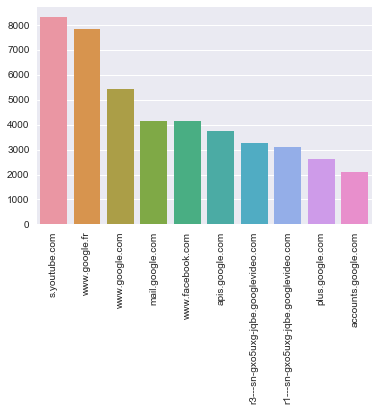

In [30]:
tops = sns.barplot(top10_sites, top10_freqs)
for item in tops.get_xticklabels():
    item.set_rotation(90)

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [31]:
train_data_10users.session_timespan.median()

37.0

**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [32]:
train_data_10users.day_of_week.median()

2.0

**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [33]:
train_data_150users.start_hour.median()

13.0

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [34]:
train_data_150users['#unique_sites'].median()

7.0

## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [31]:
# Я бы предложил оценить среднюю продолжительность сессии для пользователей, максимальную продолжительность сессии
# Также я бы записал какие сайты посетил пользователь и сколько их. Но по-скольку посмотреть каие именно сайты посетил
# пользователь мы можем и по существующим признакм, не будем дублировать. Посчитаем только количество различных сайтов по всем
# сессиям.
def feature_engineering(data,site_freq_path):
    user_id = Counter(data.user_id.values).keys()
    session_timespan_mean = []
    session_timespan_max = []
    sites = []

    for i in range(len(user_id)):
        session_timespan_mean.append(data[data.user_id == user_id[i]].session_timespan.values.mean())
        session_timespan_max.append(data[data.user_id == user_id[i]].session_timespan.values.max())
        all_sites = []
        for j in range(10):
            all_sites.extend(data[data.user_id == user_id[i]]['site'+str(j+1)].values)
        sites.append(len(np.unique(all_sites)))
    new_features = pd.DataFrame()
    new_features['user_id'] = user_id
    new_features['session_timespan_max'] = session_timespan_max
    new_features['session_timespan_mean'] = session_timespan_mean
    new_features['all_unique_sites'] = sites
    return new_features

In [32]:
new_features_10users = feature_engineering(train_data_10users,site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'))

In [33]:
new_features_150users = feature_engineering(train_data_150users,site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'))

In [34]:
new_features_10users

,user_id,session_timespan_max,session_timespan_mean,all_unique_sites
0,128,85045,1373.251431,438
1,33,85425,2106.025440,688
2,100,85801,1970.352778,508
3,39,85634,1055.492740,1161
4,237,84897,1868.199026,874
5,207,86270,1780.599572,1140
6,241,85933,2616.602996,464
7,50,85117,2578.723192,743
8,31,85826,2757.723684,962
9,127,86275,2014.441589,1276


**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

В данной выборке особо нет смысла оценивать максимальную продолжительность сессии, она примерно у всех равна. Остальные признаки давайте оценим

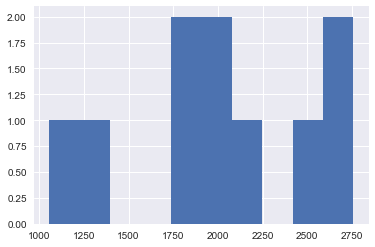

In [35]:
new_features_10users.session_timespan_mean.hist(bins = 10)

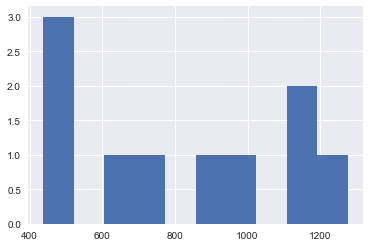

In [36]:
new_features_10users.all_unique_sites.hist(bins = 10)

Это описательные общие признаки и особой пользы для работы они не несут, давайте составим новые.

Имеет смысл оценить сколько редких и сколько популярных сайтов в сессии у пользователя

In [75]:
def prepare_train_set_with_fe2(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    # Считали словарь
    with open(site_freq_path, 'rb') as f:
        site_freq = pickle.load(f)
    # Пути к нашим csv файлам
    paths = glob(os.path.join(path_to_csv_files,'user*.csv'))
    # Достаем csv файлы пользователей
    pd_list = []
    sites_list = []
    matrix_site_list = []
    timespan_list = []
    matrix_timespan_list = []
    y_list = []

    for i in range(len(paths)):
        pd_list.append(pd.read_csv(paths[i],sep = ',', header = 0))
        pd_list[i].timestamp = pd_list[i].timestamp.apply(pd.Timestamp)
        # Достаем все сайты из этих файлов
        sites_list.append(pd_list[i]['site'].values)
        
        timespan_list.append([])
        for j in range(len(pd_list[i]['timestamp'].values)):
            timespan_list[i].append(pd_list[i]['timestamp'][j])
        # Заменяем имена на id согласно словарю
        for j in range(len(sites_list[i])):
            sites_list[i][j] = site_freq[sites_list[i][j]][0]
        sites_list[i] = sites_list[i].tolist()
        # Допишем 0 согласно размеру сессии и ширине окна
        # Преобразуем в матрицу согласно размеру окна   
        
        for j in range(0,len(sites_list[i]),window_size):
            if j+session_length > len(sites_list[i]):
                matrix_site_list.append(sites_list[i][j:len(sites_list[i])])
                matrix_timespan_list.append(timespan_list[i][j:len(timespan_list[i])])
                for t in range(j+session_length - len(sites_list[i])):
                    matrix_site_list[len(matrix_site_list)-1].append(0)
            else:
                matrix_site_list.append(sites_list[i][j:j+session_length])
                matrix_timespan_list.append(timespan_list[i][j:j+session_length])
            y_list.append(int(paths[i][len(paths[i])-8:len(paths[i])-4]))
    
    
    session_timespan = []
    unique_sites = []
    start_hour = []
    day_of_week = []
    for i in range(len(matrix_site_list)):
        if matrix_site_list[i].count(0) == 0:
            unique_sites.append(len(np.unique(matrix_site_list[i])))
        else:
            unique_sites.append(len(np.unique(matrix_site_list[i]))-1)
    matrix_site_list = np.array(matrix_site_list)
    for i in range(len(matrix_timespan_list)):
        day_of_week.append(min(matrix_timespan_list[i]).dayofweek)
        start_hour.append(min(matrix_timespan_list[i]).hour)
        session_timespan.append((max(matrix_timespan_list[i]) - min(matrix_timespan_list[i])).seconds)
    sites_pd = pd.DataFrame()
    for i in range(session_length):
        sites_pd['site'+str(i+1)] = matrix_site_list.transpose()[i]
    
    site_freq = site_freq.values()
    site_freq = sorted(site_freq, key = lambda x: x[0])
    rare_sites = np.array([0]*len(session_timespan)).tolist()
    popular_sites = np.array([0]*len(session_timespan)).tolist()
    for i in range(len(matrix_site_list)):
        for j in range(len(matrix_site_list[i])):
            if matrix_site_list[i][j] != 0:
                if site_freq[matrix_site_list[i][j]-1][1] > 1000:
                    popular_sites[i] += 1
                if site_freq[matrix_site_list[i][j]-1][1] < 10:
                    rare_sites[i] += 1

    
    sites_pd['rare_sites'] = rare_sites
    sites_pd['popular_sites'] = popular_sites
    
    sites_pd['session_timespan'] = session_timespan
    sites_pd['#unique_sites'] = unique_sites
    sites_pd['start_hour'] = start_hour
    sites_pd['day_of_week'] = day_of_week
    sites_pd['user_id'] = y_list
    
    return sites_pd

In [76]:
%%time
train_data_10users = prepare_train_set_with_fe2 (os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

Wall time: 4.03 s


In [84]:
%%time
train_data_150users = prepare_train_set_with_fe2 (os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

Wall time: 39.3 s


In [77]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,rare_sites,popular_sites,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,192,574,133,3,133,133,3,133,203,133,0,2,33,5,8,4,31
1,415,193,674,254,133,31,393,3305,217,55,1,0,284,10,8,4,31
2,55,3,55,55,5,293,415,333,897,55,0,2,258,7,8,4,31
3,473,3306,473,55,55,55,55,937,199,123,1,0,30,6,8,4,31
4,342,55,5,3307,258,211,3308,2086,675,2086,4,1,6,9,8,4,31


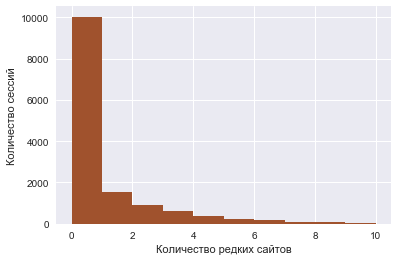

In [78]:
train_data_10users['rare_sites'].hist(facecolor = 'sienna')
plt.xlabel(u'Количество редких сайтов')
plt.ylabel(u'Количество сессий')

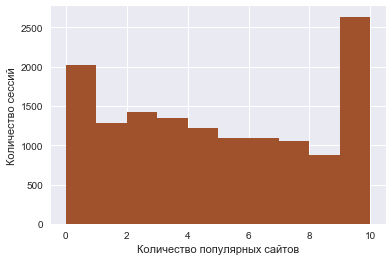

In [79]:
train_data_10users['popular_sites'].hist(facecolor = 'sienna')
plt.xlabel(u'Количество популярных сайтов')
plt.ylabel(u'Количество сессий')

In [81]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['user_id'].map(id_name_dict)
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,rare_sites,popular_sites,session_timespan,#unique_sites,start_hour,day_of_week,user_id,target
0,192,574,133,3,133,133,3,133,203,133,0,2,33,5,8,4,31,John
1,415,193,674,254,133,31,393,3305,217,55,1,0,284,10,8,4,31,John
2,55,3,55,55,5,293,415,333,897,55,0,2,258,7,8,4,31,John
3,473,3306,473,55,55,55,55,937,199,123,1,0,30,6,8,4,31,John
4,342,55,5,3307,258,211,3308,2086,675,2086,4,1,6,9,8,4,31,John


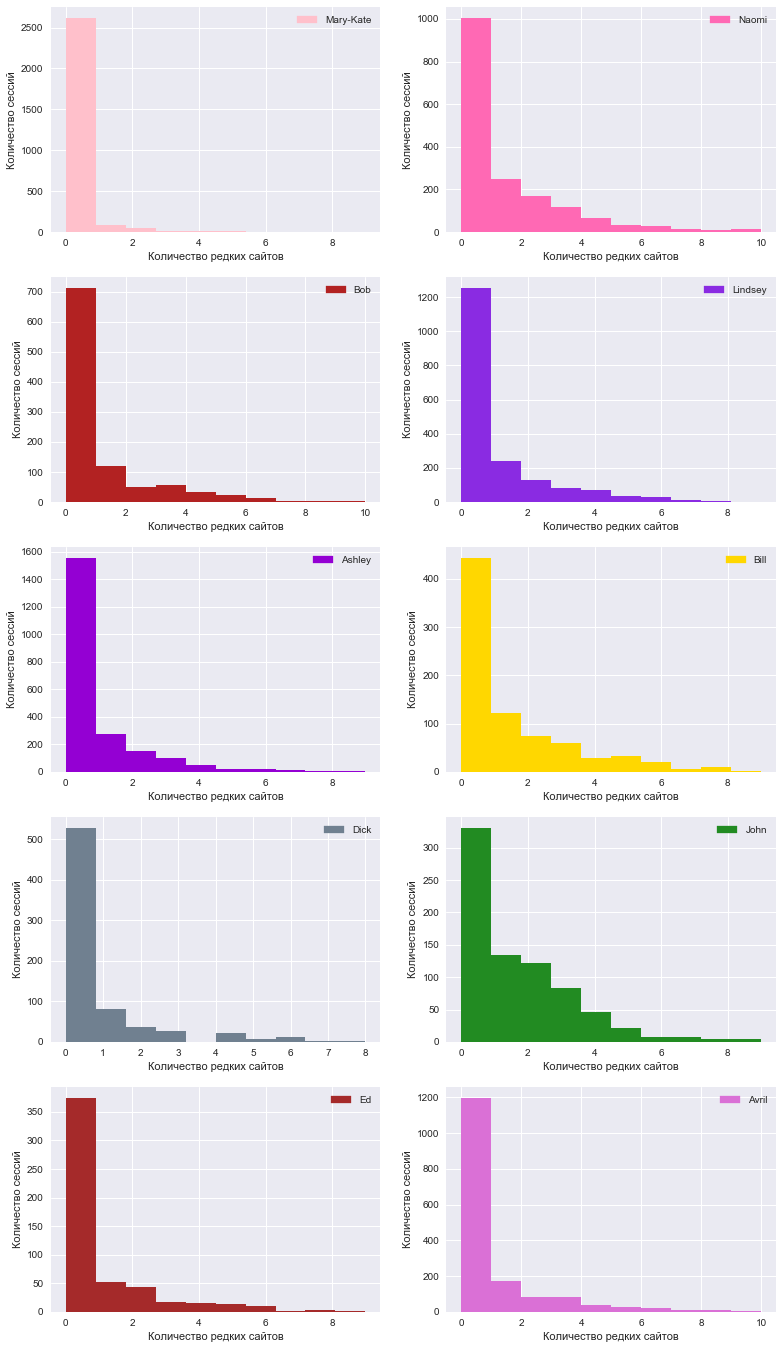

In [82]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(13, 24))
for i in range(len(color_dic)):
    axes[i%5][i%2].hist(train_data_10users[train_data_10users.target == color_dic.keys()[i]]['rare_sites'],bins = 10,facecolor = color_dic.values()[i])
    patch = mpatches.Patch(color=color_dic.values()[i], label=color_dic.keys()[i])
    axes[i%5][i%2].legend(handles=[patch])
    axes[i%5][i%2].set_xlabel(u'Количество редких сайтов')
    axes[i%5][i%2].set_ylabel(u'Количество сессий')


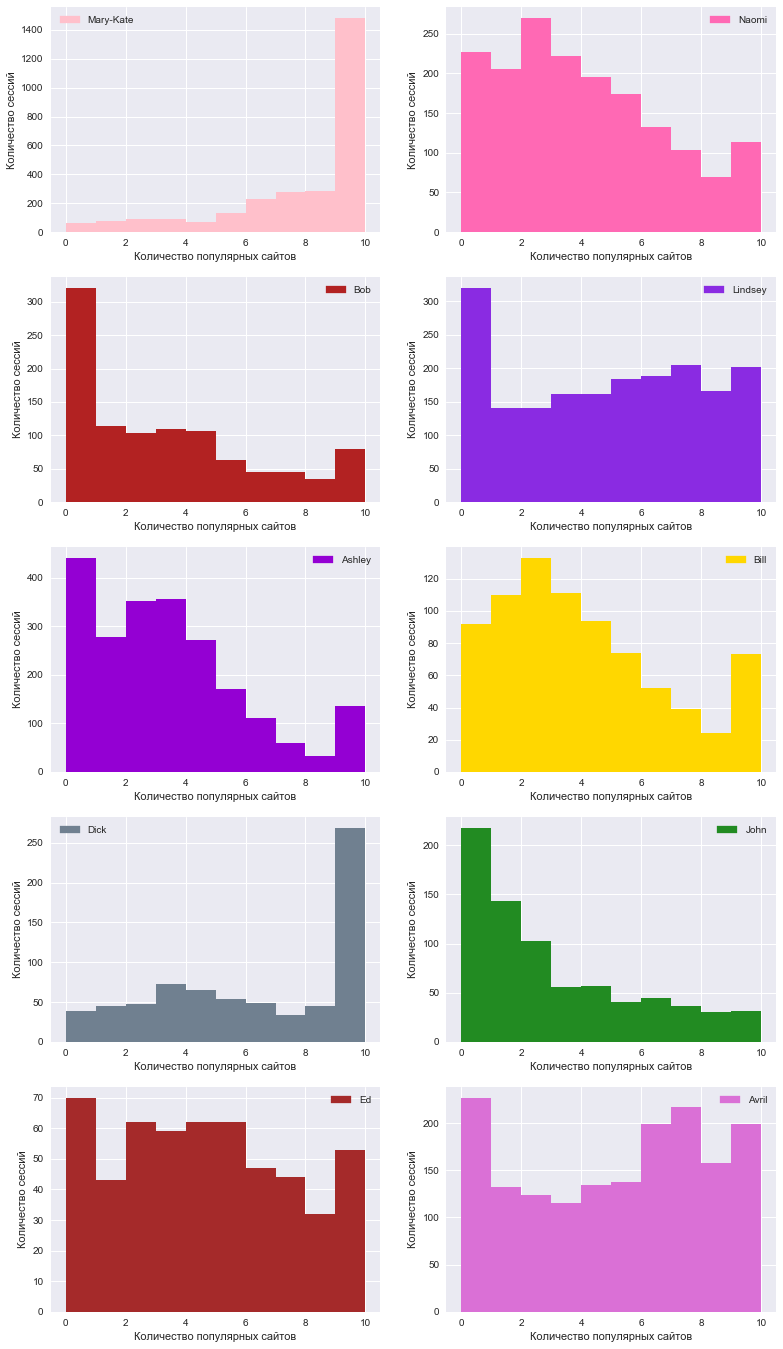

In [83]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(13, 24))
for i in range(len(color_dic)):
    axes[i%5][i%2].hist(train_data_10users[train_data_10users.target == color_dic.keys()[i]]['popular_sites'],bins = 10,facecolor = color_dic.values()[i])
    patch = mpatches.Patch(color=color_dic.values()[i], label=color_dic.keys()[i])
    axes[i%5][i%2].legend(handles=[patch])
    axes[i%5][i%2].set_xlabel(u'Количество популярных сайтов')
    axes[i%5][i%2].set_ylabel(u'Количество сессий')


Подытожим: пользователь Dick сидит в основном на двух сайтах практически каждый день, для хаккера количество сайтов маловато, скорей всего это просто соц. сети и т.д. (Update: у него много популярных сайтов в сессии))) точно сидит в соцсетях) Mary-Kate сидит по выходным, скорей всего у человека активная работа и на выходных она расслабляется. (Update: у нее также много популярных сайтов в сессии, по выходным она расслабляется!)) John редко сидит на популярных сайтах, скорей всего его интернет-сессии связаны с работой. Также по гистограмме редких сайтов он больше всех отличается. Про остальных в целом пока сказать нечего.

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

Я сохраню эти признаки отдельно, поскольку их размерность всяко меньше наших предыдущих признаков

In [85]:
selected_features_10users = train_data_10users[['rare_sites','popular_sites']]
selected_features_150users = train_data_150users[['rare_sites','popular_sites']]

In [86]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 